In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Árboles de decisión

## Fundamento Teórico

Los modelos basados en árboles dividen de forma iterativa el espacio de características en un conjunto de rectángulos y asignan a cada región resultante un valor; una clase en problemas de clasificación o un valor numérico para regresión. Está división se realiza de forma jerárquica; partiendo una región en dos de acuerdo a los valores de una variable en cada iteración. Por esta razón, una forma de representar este tipo de modelos es con un árbol binario donde cada nodo interno corresponde a una decisión (partición de acuerdo al valor de una variable) y cada hoja terminal a un resultado del modelo.

### Entrenamiento

Para entrenar un árbol de decisión se emplean heurísticas. Primero se crea un árbol que extensamente divida el espacio de características y posteriormente este árbol es “podado” reduciendo las particiones para evitar un sobre-ajuste. Para la primera parte del entrenamiento, tomando todos los datos, en cada iteración del algoritmo de entrenamiento se busca encontrar la
variable y el punto de corte que mejor separe a los datos de acuerdo a su clase.

Para distinguir la correcta separación de instancias de acuerdo a su clase existen múltiples criterios $Q$:

- Indice de Gini
- Entropía cruzada
- Error de clasificación

Dada una región del espacio de características, para partir esta región en dos se requiere una variable $j$ y un punto de corte $s$. En el caso de una variable numérica o categórica ordinal, una de estas nuevas regiones corresponde a los puntos del espacio para los cuales la variable $j$ toma valores iguales o por debajo de $s$; la segunda región corresponde a valores por encima. 

$$ R_1(j, s) = \{X | X_j \leq s\} $$
$$ R_2(j, s) = \{X | X_j \gt s\} $$

Para escoger una variable y un punto de corte, se busca minimizar la impureza de las dos nuevas regiones. Se busca entonces a la variable $j$ y el punto de corte $s$ que resuelvan:

$$ \text{min}_{(j, s)} \{ Q(R_1(j, s)) + Q(R_2(j, s)) \}$$

### Regularización

Para reducir la complejidad de modelo, el árbol es "podado" después de ser entrenado, este proceso consiste en deshacer particiones que no ofrecen una mejoría significativa en reducir la impureza de las hojas para evitar que el modelo se adapte al ruido de los datos. Además, se puede determinar un número mínimo de ejemplos por hoja del árbol para reducir las particiones de casos sumamente específicos.

## Datos

Las características se calculan a partir de una imagen digitalizada de un aspirado con aguja fina (FNA) de una masa mamaria. Describen características de los núcleos celulares presentes en la imagen.

![Imagen de celulas de un tumor](https://www.researchgate.net/profile/Nick_Street/publication/2512520/figure/fig1/AS:279373195300875@1443619168750/Initial-Approximate-Boundaries-of-Cell-Nuclei-The-user-rst-draws-a-rough-initial-outline_Q320.jpg)

La variable dependiente puede tener los siguientes valores de acuerdo al tipo de tumor

- 0: Tumor Maligno
- 1: Tumor Benigno

Se calculan diez características de valor real para cada núcleo celular. Las variables independientes son las siguientes:

1. radius: Radio
2. texture: Desviación estandar de los valores de la escala de grises de la imagen
3. perimeter: Perimetro
4. area: Area del núcleo celular en la imagen
5. smoothness: Variaciones en la longitud del radio
6. compactness: Compacidad, calculada como $\frac{\text{perimetro}^2}{\text{area}}$
7. concavity: Concavidad, número y severidad de porciones concavas del contorno
8. concave points: Número de concavidades o indentaciones
9. symmetry: Simetría
10. fractal dimension - Dimensión fractal (rugosidad)

De todas estas variables se tiene la media, valor extremo y error estándar de los núcleos celulares por tumor analizado.

### Cargar datos

Se cargan los datos utilizando la utilidad de `scikit-learn` y se preparan como `DataFrame`.

In [10]:
data = load_breast_cancer()
df = pd.DataFrame(data=data['data'], columns=data['feature_names'])
vars_cols = list(df)
df['target'] = data['target']
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


## Modelo

### Entrenamiento

Se dividen los datos de entrenamiento y evaluación. Se emplean los primeros para ajustar el modelo de árbol de decisión.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[vars_cols], df.target,
                                                    test_size=0.33, random_state=0)

# Regularizado
model = DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=0.01)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, min_samples_leaf=10)

### Evaluación

Se analizan las predicciones del modelo en el conjuntode datos de evaluación

In [4]:
y_pred = model.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_report = metrics.classification_report(y_test, y_pred)

Gráfica de matriz de confusión

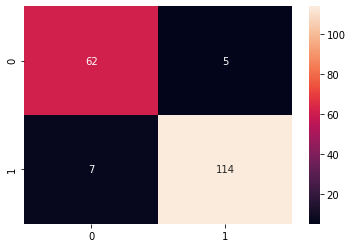

In [5]:
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.show()

In [6]:
print(class_report)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        67
           1       0.96      0.94      0.95       121

    accuracy                           0.94       188
   macro avg       0.93      0.93      0.93       188
weighted avg       0.94      0.94      0.94       188



### Visualización del árbol

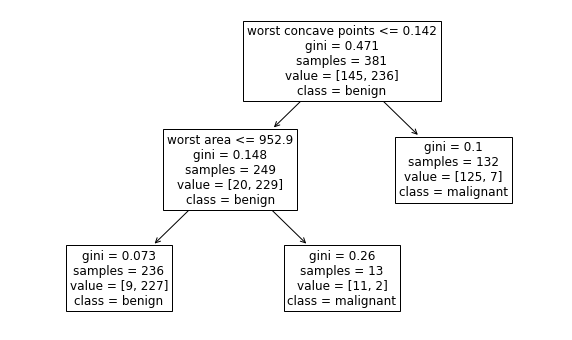

In [13]:
plt.figure(figsize=(10,6))
plot_tree(model,
          feature_names=list(data['feature_names']),
          class_names=list(data['target_names']),
#           impurity=False,
          fontsize=12)
plt.show()

## Interpretación

El modelo entrenado muestra una precisión del 94% con una buena sensibilidad en las 2 clases (por encima del 90%). Observando la matriz de confusión notamos que son pocos los casos que el modelo erra en clasificar. En general podemos decir que tenemos un buen modelo predictivo para este problema.

Observando el árbol de decisión observamos que la primer partición reduce considerablemente la impureza y se realiza de acuerdo a la variable del valor extremo del número de concavidades en el núcleo celular, donde un mayor número está asociado a tumores malignos. Debajo de este número de concavidades la mayoría de los tumores son benignos con excepción de aquellos en los que se observa un valor extremo de área muy alto. 

Cabe notar que las variables utilizadas por el árbol coinciden con algunas de las encontradas por el estudio original que presentó por primera vez este conjunto de datos.

## Referencias

- Breiman, L., Friedman, J. H., Olshen, R. A., & Stone, C. J. (1984). Classification and Regression Trees. Wadsworth Publishing Company.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning. Springer New York. https://doi.org/10.1007/978-0-387-84858-7
- Street, W. N., Wolberg, W. H., & Mangasarian, O. L. (1993). Nuclear feature extraction for breast tumor diagnosis. In R. S. Acharya & D. B. Goldgof (Eds.), Biomedical Image Processing and Biomedical Visualization. SPIE. https://doi.org/10.1117/12.148698